In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import regex as re

In [270]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select b.description, c.description, d.description from DatixCRM.dbo.code_unit b join DatixCRM.dbo.incidents_main a on a.inc_unit = b.code join DatixCRM.dbo.code_specialty c on a.inc_specialty = c.code join DatixCRM.dbo.code_locactual d on a.inc_locactual=d.code where a.inc_type='PAT' and a.inc_category='MEDIC' and a.inc_organisation='QA' and d.cod_parent2='QA'"
df = pd.read_sql(query, sql_conn)
df.columns = ['division-care_group','specialty','location']
df.head()

,division-care_group,specialty,location
0,Medicine & Urgent Care Division - Medicine,Respiratory,E6/7
1,Medicine & Urgent Care Division - Medicine,General Medicine,C5
2,Medicine and Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED)
3,Medicine & Urgent Care Division - Medicine,Cardiology,C7
4,Surgical and Outpatients Division - MSK / Head...,Orthopaedic,D5


In [271]:
df['division-care_group'] = df['division-care_group'].str.replace(' and ',' & ')
df['specialty'] = df['specialty'].str.replace(' and ',' & ')
df['specialty'] = df['specialty'].str.replace('Ear Nose & Throat','ENT')
df['specialty'] = df['specialty'].str.replace('/ ','/')
divider = df['division-care_group'].str.split(" Division - ",n=1,expand=True)
df['division'] = divider[0]
df['care_group'] = divider[1]
#df['division'] = df['division'].str.replace(' and ',' & ')
df.loc[df.division == 'Corporate Functions', 'care_group'] = 'Corporate Functions'
df = df[df['division-care_group'] != 'Corporate Functions']
#df = df[df.care_group != 'Pathology']
#df = df[df.care_group != 'Patient Administration Services']
#df.loc[df.division == 'Surgical & Outpatients', 'division'] = 'Surgical & Outpatients + Corporate Functions'
#df.loc[df.division == 'Corporate Functions', 'division'] = 'Surgical & Outpatients + Corporate Functions'

In [272]:
division_counts = df['division'].value_counts()
division_percentages = 100*division_counts/sum(division_counts.values)
division_labels = [str(i) for i in division_counts.index]
print(division_percentages)

Medicine & Urgent Care    45.424032
Networked Services        20.642202
Clinical Delivery         17.073171
Surgical & Outpatients    16.860595
Name: division, dtype: float64


In [273]:
df['division_sorted'] = pd.Categorical(df['division'], division_labels)
df = df.sort_values("division_sorted")
df.head()

,division-care_group,specialty,location,division,care_group,division_sorted
0,Medicine & Urgent Care Division - Medicine,Respiratory,E6/7,Medicine & Urgent Care,Medicine,Medicine & Urgent Care
4573,Medicine & Urgent Care Division - Urgent Care,Acute Medicine for Older People,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care
4567,Medicine & Urgent Care Division - Older Person...,Acute Medicine for Older People,G3,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care
4564,Medicine & Urgent Care Division - Medicine,Pharmacy,Respiratory Day Unit,Medicine & Urgent Care,Medicine,Medicine & Urgent Care
4563,Medicine & Urgent Care Division - Older Person...,Acute Stroke,TIA Clinic,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care


In [274]:
specialty_labels = []
for i in division_counts.index:
    df_division = df[df.division == i]
    per_division_counts = df_division['specialty'].value_counts()
    specialty_labels += [i + ' - ' + str(j) for j in per_division_counts.index]
print(specialty_labels)

['Medicine & Urgent Care - Acute Medical Unit', 'Medicine & Urgent Care - Emergency Department', 'Medicine & Urgent Care - General Medicine', 'Medicine & Urgent Care - Acute Medicine for Older People', 'Medicine & Urgent Care - Cardiology', 'Medicine & Urgent Care - Respiratory', 'Medicine & Urgent Care - Gastroenterology', 'Medicine & Urgent Care - Acute Stroke', 'Medicine & Urgent Care - Stroke Rehabilitation', 'Medicine & Urgent Care - Neuro Rehabilitation', 'Medicine & Urgent Care - Paediatrics', 'Medicine & Urgent Care - Pharmacy', 'Medicine & Urgent Care - Diabetics & Endocrinology', 'Medicine & Urgent Care - Administration Medicine Clinical Service Centre', 'Medicine & Urgent Care - Orthopaedic', 'Medicine & Urgent Care - General Surgery', 'Medicine & Urgent Care - Urology', 'Medicine & Urgent Care - Haematology', 'Medicine & Urgent Care - Administration Emergency', 'Medicine & Urgent Care - Nephrology/Renal medicine', 'Medicine & Urgent Care - Vascular Services', 'Medicine & Ur

In [275]:
care_group_labels = []
for i in division_counts.index:
    df_division = df[df.division == i]
    per_division_counts = df_division['care_group'].value_counts()
    care_group_labels += [str(i) for i in per_division_counts.index]
df['care_group_sorted'] = pd.Categorical(df['care_group'], care_group_labels)
df = df.sort_values(['division_sorted','care_group_sorted'])
care_group_counts = df['care_group'].value_counts()[df['care_group'].unique()]
care_group_percentages = 100*care_group_counts/sum(care_group_counts.values)

In [276]:
specialty_labels = [re.sub(r"Surgical\s&\sOutpatients\s-\s(.+)\sSurgery",r"Surgical & Outpatients - \1",s) for s in specialty_labels]
df.specialty = df.specialty.str.replace(' Surgery','')
df['care_group-specialty'] = df['care_group'] + ' - ' + df['specialty']
df['specialty_sorted'] = pd.Categorical(df['care_group-specialty'], specialty_labels)
df = df.sort_values(['division_sorted','care_group_sorted','specialty_sorted'])
df.head()

,division-care_group,specialty,location,division,care_group,division_sorted,care_group_sorted,care_group-specialty,specialty_sorted
4573,Medicine & Urgent Care Division - Urgent Care,Acute Medicine for Older People,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - Acute Medicine for Older People,NaN
4562,Medicine & Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - Emergency Department,NaN
4552,Medicine & Urgent Care Division - Urgent Care,General Medicine,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - General Medicine,NaN
4536,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - Acute Medical Unit,NaN
4534,Medicine & Urgent Care Division - Urgent Care,Emergency Department,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - Emergency Department,NaN


In [277]:
specialty_counts = df['division-specialty'].value_counts()[df['division-specialty'].unique()]
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)
print(specialty_percentages)

KeyError: 'division-specialty'

In [257]:
for specialty,percentage in specialty_percentages.iteritems():
    if percentage < 1.231527 + 0.000001:
        df.loc[df['division-specialty'] == specialty, 'division-specialty'] = specialty.split(" - ")[0] + ' - Other'

In [258]:
specialty_counts = df['division-specialty'].value_counts()[df['division-specialty'].unique()]
print(specialty_counts)
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)
specialty_labels_split = specialty_counts.index.str.split(" - ",n=1)
specialty_labels = [el[1] for el in specialty_labels_split]
print(specialty_percentages)

Medicine & Urgent Care - Acute Medical Unit                 882
Medicine & Urgent Care - Emergency Department               627
Medicine & Urgent Care - General Medicine                   557
Medicine & Urgent Care - Acute Medicine for Older People    540
Medicine & Urgent Care - Cardiology                         433
Medicine & Urgent Care - Respiratory                        339
Medicine & Urgent Care - Gastroenterology                   259
Medicine & Urgent Care - Acute Stroke                       180
Medicine & Urgent Care - Other                              243
Networked Services - Obstetrics & Maternity                 334
Networked Services - NICU                                   231
Networked Services - Paediatrics                            205
Networked Services - Other                                  265
Networked Services - Oncology                               453
Networked Services - Haematology                            130
Networked Services - Nephrology/Renal me

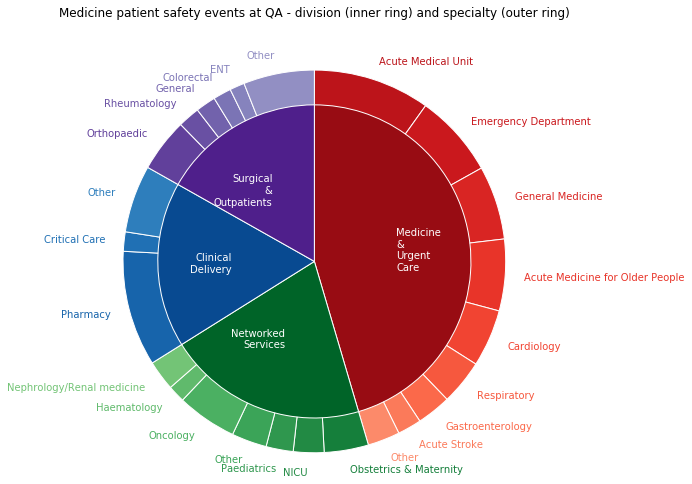

In [259]:
# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
inner_ring_colours = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
division_colour_dict = {'Medicine & Urgent Care':plt.cm.Reds, 'Networked Services':plt.cm.Greens, 'Surgical & Outpatients':plt.cm.Blues, 'Clinical Delivery':plt.cm.Purples}

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[inner_ring_colours[0](0.9), inner_ring_colours[1](0.9), inner_ring_colours[2](0.9), inner_ring_colours[3](0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
#specialty_colours = [a(0.8), a(0.7), a(0.6), a(0.5), b(0.8), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
specialty_colours = []
for i,index in enumerate(division_counts.index):
    df_division = df[df.division == index]
    per_division_counts = df_division['division-specialty'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        specialty_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 0.5

mypie2, texts = ax.pie(specialty_counts, radius=2.2, labels=specialty_labels, colors=specialty_colours, startangle=90, counterclock=False)
plt.setp( mypie2, width=0.4, edgecolor='white')
for text, color in zip(texts, specialty_colours):
    text.set_color(color)
plt.margins(0,0)

plt.title('Medicine patient safety events at QA - division (inner ring) and specialty (outer ring)', y=1.6);

In [262]:
for specialty,percentage in specialty_percentages.iteritems():
    if percentage < 0.860021:
        df.loc[df['care_group-specialty'] == specialty, 'care_group-specialty'] = specialty.split(" - ")[0] + ' - Other'

specialty_counts = df['care_group-specialty'].value_counts()[df['care_group-specialty'].unique()]
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)
specialty_labels_split = specialty_counts.index.str.split(" - ",n=1)
specialty_labels = [el[1] for el in specialty_labels_split]
print(specialty_percentages)

df.loc[df.location == 'Department of Critical Care (E5) (DCCQ)', 'location'] = 'E5'
df.loc[df.location == 'Acute Medical Unit (AMU) (MAU)', 'location'] = 'AMU'
df.loc[df.location == 'Haematology & Oncology Day Unit (HODU)', 'location'] = 'HODU'
df.loc[df.location == 'Childrens Assesment Unit (CAU)', 'location'] = 'CAU'
df.loc[df.location == 'Hepatology Clinic (Nurse led) (on C5)', 'location'] = 'Hepatology'
df.loc[df.location == 'Cardiac Day Unit (CDU)', 'location'] = 'CDU'
df.loc[df.location == 'Surgical Assessment Unit (SAU)', 'location'] = 'SAU'
df.location = df.location.str.replace(' QA','')
df.location = df.location.str.replace(' Department','')
df.location = df.location.str.replace(' Unit','')
df.location = df.location.str.replace(' Centre','')
df.location = df.location.str.replace(' Clinic','')
df.location = df.location.str.replace(' and ',' & ')
df.loc[df.location == 'Theatre Admissions Suite (TAS)', 'location'] = 'TAS'
df.loc[df.location == 'Pre-Operative Assessment (POA)', 'location'] = 'POA'
df.loc[df.location == 'Theatre - D1', 'location'] = 'D1'
df.loc[df.location == 'Research & Development', 'location'] = 'R&D'
df.loc[df.location == 'Reception (Atrium)', 'location'] = 'Reception'
df.loc[df.location == 'G5 Endoscopy Suites', 'location'] = 'G5'
df.loc[df.location == 'F3 Stroke Rehabilitation', 'location'] = 'F3'
df.loc[df.location == 'F4 Acute Stroke Ward', 'location'] = 'F4'
df.loc[df.location == 'F1  Neuro Rehab', 'location'] = 'F1'
df.loc[df.location == 'Emergency (ED)', 'location'] = 'ED'
df.loc[df.location == 'B6  Antenatal Ward', 'location'] = 'B6'
df.loc[df.location == 'B7 Postnatal Ward', 'location'] = 'B7'
df.loc[df.location == 'B9 NICU', 'location'] = 'B9'
df.loc[df.location == 'A7 Starfish', 'location'] = 'A7'
df.loc[df.location == 'A8 Shipwreck', 'location'] = 'A8'
df.loc[df.location == 'B5  - Mary Rose Ward', 'location'] = 'B5'
df.loc[df.location == 'B8 Labour Ward', 'location'] = 'B8'
df.loc[df.location == 'Radiotherapy  Dept within CHOC', 'location'] = 'Radiotherapy'
df.loc[df.location == 'Surgical High Care (SHCU)', 'location'] = 'SHCU'

location_counts = df['location'].value_counts()[df['location'].unique()]

location_labels = []
for i in care_group_counts.index:
    df_care_group = df[df.care_group == i]
    per_care_group_counts = df_care_group['location'].value_counts()
    location_labels += [i + ' - ' + str(j) for j in per_care_group_counts.index]

df['care_group-location'] = df['care_group'] + ' - ' + df['location']

location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)

for location,percentage in location_percentages.iteritems():
    if percentage < 0.701596 + 0.000001:
        df.loc[df['care_group-location'] == location, 'care_group-location'] = location.split(" - ")[0] + ' - Other'

location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)
print(location_percentages)
location_labels_split = location_counts.index.str.split(" - ",n=1)
location_labels = [el[1] for el in location_labels_split]

Medicine & Urgent Care - AMU                          9.861204
Medicine & Urgent Care - ED                           7.868816
Medicine & Urgent Care - Other                        2.205059
Medicine & Urgent Care - D2                           3.066935
Medicine & Urgent Care - C5                           2.316991
Medicine & Urgent Care - E8                           2.261025
Medicine & Urgent Care - C6                           3.816879
Medicine & Urgent Care - D7                           0.805910
Medicine & Urgent Care - D3                           1.768525
Medicine & Urgent Care - E6/7                         1.399149
Medicine & Urgent Care - C7                           1.141706
Medicine & Urgent Care - F4                           2.149093
Medicine & Urgent Care - G2                           0.783524
Medicine & Urgent Care - G3                           1.063353
Medicine & Urgent Care - G4                           0.962615
Medicine & Urgent Care - F2                           1

'\nfor location,percentage in location_percentages.iteritems():\n    if percentage < 0.701596 + 0.000001:\n        df.loc[df[\'division-location\'] == location, \'division-location\'] = location.split(" - ")[0] + \' - Other\'\n\nlocation_counts = df[\'division-location\'].value_counts()[df[\'division-location\'].unique()]\nlocation_percentages = 100*location_counts/sum(location_counts.values)\nprint(location_percentages)\nlocation_labels_split = location_counts.index.str.split(" - ",n=1)\n\ndf_location_percentages = pd.DataFrame(location_percentages)\ndf_location_percentages[\'division\'] = df_location_percentages.index.to_series().str.split(\' - \').str[0]\ndf_divisions = {}\nfor division in division_labels:\n    df_divisions[division] = df_location_percentages.loc[df_location_percentages[\'division\']==division]\n'

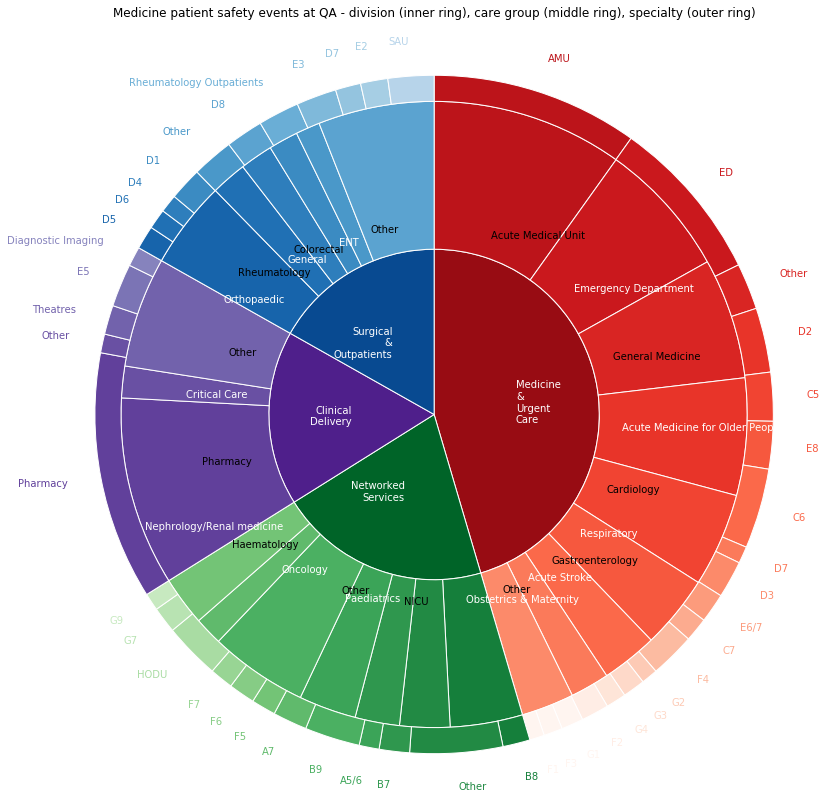

In [263]:
# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
division_colour_dict = {'Medicine & Urgent Care':plt.cm.Reds, 'Networked Services':plt.cm.Greens, 'Surgical & Outpatients':plt.cm.Blues, 'Clinical Delivery':plt.cm.Purples}
inner_ring_colours = [division_colour_dict[division] for division in division_labels]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[inner_ring_colours[0](0.9), inner_ring_colours[1](0.9), inner_ring_colours[2](0.9), inner_ring_colours[3](0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
#specialty_colours = [a(0.8), a(0.7), a(0.6), a(0.5), b(0.8), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
specialty_colours = []
for i,index in enumerate(division_counts.index):
    df_division = df[df.division == index]
    per_division_counts = df_division['division-specialty'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        specialty_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 0.5
mypie2, texts = ax.pie(specialty_counts, radius=3.6, labels=specialty_labels, labeldistance=0.6, colors=specialty_colours, textprops={'color':'k'},startangle=90, counterclock=False)
plt.setp( mypie2, width=1.7, edgecolor='white')
specialty_label_colours = ['k' if i%2==0 else 'w' for i in range(len(specialty_counts))]
for text, color in zip(texts, specialty_label_colours):
    text.set_color(color)
plt.margins(0,0)

# Third Ring (oUTside)
location_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    per_division_counts = df_division['division-location'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        location_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 0.5
mypie3, texts = ax.pie(location_counts, radius=3.9, labels=location_labels, colors=location_colours, startangle=90, counterclock=False)
plt.setp( mypie3, width=0.3, edgecolor='white')
for text, color in zip(texts, location_colours):
    text.set_color(color)
plt.margins(0,0)

plt.title('Medicine patient safety events at QA - division (inner ring), care group (middle ring), specialty (outer ring)', y=2.3);

In [164]:
for specialty,percentage in specialty_percentages.iteritems():
    if percentage < 0.860021:
        df.loc[df['care_group-specialty'] == specialty, 'care_group-specialty'] = specialty.split(" - ")[0] + ' - Other'

specialty_counts = df['care_group-specialty'].value_counts()[df['care_group-specialty'].unique()]
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)
specialty_labels_split = specialty_counts.index.str.split(" - ",n=1)
specialty_labels = [el[1] for el in specialty_labels_split]
print(specialty_percentages)

df.loc[df.location == 'Department of Critical Care (E5) (DCCQ)', 'location'] = 'E5'
df.loc[df.location == 'Acute Medical Unit (AMU) (MAU)', 'location'] = 'AMU'
df.loc[df.location == 'Haematology & Oncology Day Unit (HODU)', 'location'] = 'HODU'
df.loc[df.location == 'Childrens Assesment Unit (CAU)', 'location'] = 'CAU'
df.loc[df.location == 'Hepatology Clinic (Nurse led) (on C5)', 'location'] = 'Hepatology'
df.loc[df.location == 'Cardiac Day Unit (CDU)', 'location'] = 'CDU'
df.loc[df.location == 'Surgical Assessment Unit (SAU)', 'location'] = 'SAU'
df.location = df.location.str.replace(' QA','')
df.location = df.location.str.replace(' Department','')
df.location = df.location.str.replace(' Unit','')
df.location = df.location.str.replace(' Centre','')
df.location = df.location.str.replace(' Clinic','')
df.location = df.location.str.replace(' and ',' & ')
df.loc[df.location == 'Theatre Admissions Suite (TAS)', 'location'] = 'TAS'
df.loc[df.location == 'Pre-Operative Assessment (POA)', 'location'] = 'POA'
df.loc[df.location == 'Theatre - D1', 'location'] = 'D1'
df.loc[df.location == 'Research & Development', 'location'] = 'R&D'
df.loc[df.location == 'Reception (Atrium)', 'location'] = 'Reception'
df.loc[df.location == 'G5 Endoscopy Suites', 'location'] = 'G5'
df.loc[df.location == 'F3 Stroke Rehabilitation', 'location'] = 'F3'
df.loc[df.location == 'F4 Acute Stroke Ward', 'location'] = 'F4'
df.loc[df.location == 'F1  Neuro Rehab', 'location'] = 'F1'
df.loc[df.location == 'Emergency (ED)', 'location'] = 'ED'
df.loc[df.location == 'B6  Antenatal Ward', 'location'] = 'B6'
df.loc[df.location == 'B7 Postnatal Ward', 'location'] = 'B7'
df.loc[df.location == 'B9 NICU', 'location'] = 'B9'
df.loc[df.location == 'A7 Starfish', 'location'] = 'A7'
df.loc[df.location == 'A8 Shipwreck', 'location'] = 'A8'
df.loc[df.location == 'B5  - Mary Rose Ward', 'location'] = 'B5'
df.loc[df.location == 'B8 Labour Ward', 'location'] = 'B8'
df.loc[df.location == 'Radiotherapy  Dept within CHOC', 'location'] = 'Radiotherapy'
df.loc[df.location == 'Surgical High Care (SHCU)', 'location'] = 'SHCU'

location_counts = df['location'].value_counts()[df['location'].unique()]

location_labels = []
for i in care_group_counts.index:
    df_care_group = df[df.care_group == i]
    per_care_group_counts = df_care_group['location'].value_counts()
    location_labels += [i + ' - ' + str(j) for j in per_care_group_counts.index]

df['care_group-location'] = df['care_group'] + ' - ' + df['location']

location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)

for location,percentage in location_percentages.iteritems():
    if percentage < 0.701596 + 0.000001:
        df.loc[df['care_group-location'] == location, 'care_group-location'] = location.split(" - ")[0] + ' - Other'

location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)
print(location_percentages)
location_labels_split = location_counts.index.str.split(" - ",n=1)
location_labels = [el[1] for el in location_labels_split]
df_location_percentages = pd.DataFrame(location_percentages)
df_location_percentages['care_group'] = df_location_percentages.index.to_series().str.split(' - ').str[0]
df_care_groups = {}
for care_group in care_group_labels:
    df_care_groups[care_group] = df_location_percentages.loc[df_location_percentages['care_group']==care_group]

Urgent Care - Acute Medical Unit                                9.697861
Urgent Care - Emergency Department                              7.038588
Urgent Care - Other                                             2.263211
Medicine - General Medicine                                     5.635397
Medicine - Cardiology                                           4.752744
Medicine - Respiratory                                          3.621138
Medicine - Gastroenterology                                     2.851646
Medicine - Other                                                0.746860
Older Persons Medicine - Acute Medicine for Older People        5.431708
Older Persons Medicine - Acute Stroke                           1.901098
Older Persons Medicine - Other                                  1.663460
Women & Children's - Obstetrics and Maternity                   3.722983
Women & Children's - NICU                                       2.591377
Women & Children's - Paediatrics                   

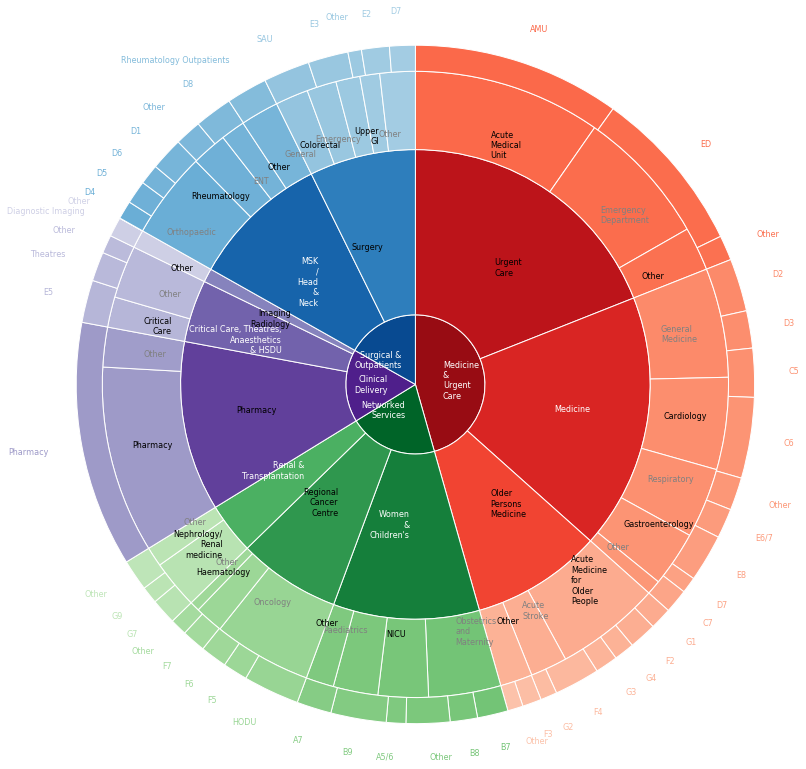

In [165]:
plt.rcParams.update({'font.size': 8})

# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
division_colour_dict = {'Medicine & Urgent Care':plt.cm.Reds, 'Networked Services':plt.cm.Greens, 'Surgical & Outpatients':plt.cm.Blues, 'Clinical Delivery':plt.cm.Purples}
inner_ring_colours = [division_colour_dict[division] for division in division_labels]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
division_labels_newlines[division_labels_newlines.index('Surgical\n&\nOutpatients')] = 'Surgical &\nOutpatients'
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=0.8, labels=division_labels_newlines, labeldistance=0.4, colors=[inner_ring_colours[0](0.9), inner_ring_colours[1](0.9), inner_ring_colours[2](0.9), inner_ring_colours[3](0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=0.8, edgecolor='white')
 
# Second Ring (oUTside)
care_group_labels_newlines = [i.replace(' ','\n') for i in care_group_labels]
care_group_labels_newlines[care_group_labels_newlines.index('Renal\n&\nTransplantation')] = 'Renal &\nTransplantation'
care_group_labels_newlines[care_group_labels_newlines.index('Critical\nCare,\nTheatres,\nAnaesthetics\n&\nHSDU')] = 'Critical Care, Theatres,\nAnaesthetics\n& HSDU'
#care_group_labels_newlines[care_group_labels_newlines.index('Imaging\nRadiology')] = 'Imaging Radiology'
#care_group_colours = [a(0.8), a(0.7), a(0.6), a(0.5), b(0.8), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
care_group_colours = [a(0.8), a(0.7), a(0.6), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
care_group_colours = []
for i,index in enumerate(division_counts.index):
    df_division = df[df.division == index]
    per_division_counts = df_division['care_group'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        care_group_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 1
mypie2, texts = ax.pie(care_group_counts, radius=2.7, labels=care_group_labels_newlines, labeldistance=0.6, colors=care_group_colours, textprops={'color':'k'},startangle=90, counterclock=False)
plt.setp( mypie2, width=1.9, edgecolor='white')
care_group_label_colours = ['k' if i%2==0 else 'w' for i in range(len(care_group_counts))]
for text, color in zip(texts, care_group_label_colours):
    text.set_color(color)
plt.margins(0,0)

# Third Ring (oUTside)
specialty_labels_newlines = [i.replace(' ','\n') for i in specialty_labels]
specialty_labels_newlines[specialty_labels_newlines.index('Ear\nNose\nand\nThroat')] = 'ENT'
specialty_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    slice_colour_orig = 0.5
    division_care_group_counts = df_division['care_group'].value_counts()[df_division['care_group'].unique()]
    for j,care_index in enumerate(division_care_group_counts.index):
        df_care_group = df_division[df_division['care_group-specialty'].str.startswith(care_index)]
        per_care_group_counts = df_care_group['care_group-specialty'].value_counts()[df_care_group['care_group-specialty'].unique()]
        slice_colour = slice_colour_orig - j/10
        for k in per_care_group_counts:
            specialty_colours.append(inner_ring_colours[i](slice_colour))
            slice_colour -= 0.01
mypie3, texts = ax.pie(specialty_counts, radius=3.6, labels=specialty_labels_newlines, labeldistance=0.8, colors=specialty_colours, startangle=90, counterclock=False)
plt.setp( mypie3, width=0.9, edgecolor='white')
specialty_label_colours = ['k' if i%2==0 else 'gray' for i in range(len(specialty_counts))]
for text, color in zip(texts, specialty_label_colours):
    text.set_color(color)
plt.margins(0,0)

# Fourth Ring (oUTside)
location_colours = [a(0.5),a(0.49),a(0.48),a(0.47),a(0.4),a(0.39),a(0.38),a(0.37),a(0.36),a(0.35),a(0.34),a(0.33),a(0.32),a(0.31),a(0.30),a(0.29),a(0.28),a(0.27),a(0.26),a(0.25),a(0.24),c(0.50),c(0.49),c(0.48),c(0.47),c(0.46),c(0.45),c(0.40),c(0.39),c(0.38),c(0.37),c(0.36),c(0.30),c(0.29),c(0.28),c(0.27),d(0.50),d(0.40),d(0.39),d(0.38),d(0.37),d(0.30),e(0.50),e(0.49),e(0.48),e(0.47),e(0.46),e(0.45),e(0.44),e(0.40),e(0.39),e(0.38),e(0.37)]
location_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    slice_colour_orig = 0.5
    division_care_group_counts = df_division['care_group'].value_counts()[df_division['care_group'].unique()]
    for j,care_index in enumerate(division_care_group_counts.index):
        df_care_group = df_division[df_division['care_group-location'].str.startswith(care_index)]
        per_care_group_counts = df_care_group['care_group-location'].value_counts()[df_care_group['care_group-location'].unique()]
        slice_colour = slice_colour_orig - j/10
        for k in per_care_group_counts:
            location_colours.append(inner_ring_colours[i](slice_colour))
            slice_colour -= 0.01
mypie4, texts = ax.pie(location_counts, radius=3.9, labels=location_labels, colors=location_colours, startangle=90, counterclock=False)
plt.setp( mypie4, width=0.3, edgecolor='white')
for text, color in zip(texts, location_colours):
    text.set_color(color)
plt.margins(0,0)